In [1]:
import os
from time import time

#define classes to hold primer set information
class gene:
    def __init__(self, name, primers):
        self.name = name
        self.primers = primers
        return
    
class primer_pair:
    def __init__(self, A, B, name, count):
        self.id = f"{name}-{count}"
        self.gene = name
        self.dimer = 999
        self.fseq = A.split("+")[0]
        self.rseq = A.split("+")[3]
        self.fstart = A.split("+")[2]
        self.penalty = B.split("-")[0]
        self.ftm = B.split("-")[1]
        self.rtm = B.split("-")[2]
        self.ampliconlen = B.split("-")[3]
        self.path = []
        self.neighbours = []
        return  



In [3]:
#import the primer set generated from step 1
import pickle

os.chdir("/home/flan3@ad.wisc.edu/MplexPrimerPicker/projects/mockcommunity")

with open("Primers.pickle", "rb") as infile:
    genelist = pickle.load(infile)

glist = []
count = 0
for g in genelist:
    plist = []
    for p in genelist[g]:
        plist.append(p)
        #print(p.id)
        count+= 1
    glist.append(gene("|".join(p.gene.split("|")[-2:]), plist))
genelist = glist
print(count, "total primers")

#IMPORTANT: set the num_unchangeable variable to correspond to the number of primers that cannot be changed (such as adaptors)
num_unchangeable = 2

#IMPORTANT: move the adaptor primers - the 16S and P5/P7 primers (which have no alternatives) to the top slots - they will not be ignored
#when selecting primers to change in the primer selection process
genelist.insert(0, genelist.pop(-1))
genelist.insert(0, genelist.pop(-1))

#IMPORTANT: print list of genes and double check that all unchangeable primers at on top of the list
for g in genelist:
    print(g.name)

802 total primers
P5/P7
16S
Sepiderm-dnaG
Pputida-dnaG
Llactis-dnaG
Bfragilis-rpoB
Chiranonis-rpoB
Ecoli-rpoB
Bsubtilis-rpoB
RFP


In [5]:
#load the calculated primer dimer free energies from script 2
import pickle
with open("dimerization-deltaGs.pickle", "rb") as infile:
    adjdict = pickle.load(infile)

In [6]:
#simulated annealing algorithm to find primer pools with lowest likelihood of forming primer dimers
import random
import numpy as np
from time import process_time
import sys

#This function just gets the deltaG scores for specified primerset pairs, calculated from script 2.
def get_scores(pmr1, pmr2): 
    return adjdict[frozenset((pmr1.id,pmr2.id))]

def sim_anneal(T = 10, length = 1, beta = 0.99):
    #THIS ALGORITHM ASSUMES P5/P7 and 16S are the first 2 in the list of genes!
    #FOR OTHER CASES WHERE THIS DOES NOT APPLY, MODIFY THE FOLLOWING IF STATEMENT
    if genelist[0].name != "P5/P7" or genelist[1].name != "16S":
        print("Gene order not as expected! Exiting")
        return "error"
    #########################################################
    min_history = [] #keep track of scores to see how the annealing is doing
    avg_history = [] #keep track of scores to see how the annealing is doing
    Temp_history = [] #keep track of temperature history for adjusting
    tstart = time() 
    tend = tstart + 60*length #length is input as minutes
    cycles = 0 #keep track of how many cycles we've done
    bestscore = -9999
    bestset = [] #keep track of the best set of primers identified 

    #1. start with an initial random state
    pset = []
    for g in genelist: #making sure that the order of genes in the pset is same as order in "genes"
        pset.append(random.choice(g.primers))

    #calculate score for this set
    scores1 = np.zeros((len(pset),len(pset))) 
    for i in range(len(pset)):
        for j in range(i): #every comparison between different primersets
            scores1[i,j] = get_scores(pset[i], pset[j])
            scores1[j,i] = scores1[i,j] #make it symmetrical for later row-summing reasons

    #start iterating through simulated annealing
    while time() < tend: #timed annealing process

        #2. propose a new random set where one gene is changed
        psetnew = pset

        scoresrow = np.sum(scores1, axis = 0) #sum the rows to get aggregate scores for each primer to help choose which one to change   
        
        #probabilistic picking of worst performing gene or any random gene
        if random.random() >= 0.2: #80% most of the time pick the worst performrng primer to change
            c = np.argmin(scoresrow[num_unchangeable:])+num_unchangeable  #select the position with worst score to change 
            #exclude the unchangeable primers from this selection process, as there are no alternatives anyways
        else:
            c = random.choice(range(len(pset))) #20% of the time, just choose random primer to change
            
        psetnew[c] = random.choice(genelist[c].primers) #get a new primer for that position

        #3. score new primer set
        scores2 = np.zeros((len(pset),len(pset))) 
        for i in range(len(pset)):
            for j in range(i+1, len(pset)):
                scores2[i,j] = get_scores(psetnew[i], psetnew[j])
                scores2[j,i] = scores2[i,j]

        #4. compare both scores and decide to accept or not
        E1 = -1*np.mean(scores1)
        E2 = -1*np.mean(scores2)
        if E1 > E2: #update it if old score is worse than new score
            pset = psetnew
            scores1 = scores2 #also update the scores
        else:
            if np.exp(-(E2-E1)/T) > random.random():   #also probability of taking newpset even if it isn't better
                pset = psetnew
                scores1 = scores2 #also update the scores

        #also keep track of the best performing set in history #we'll make a combo of min + avg scores
        if np.mean(bestscore) + np.amin(bestscore)/2 < np.mean(scores2) + np.amin(scores2)/2: #bestset is worse than score2
            #update bestset 
            bestscore = scores2
            bestset = psetnew
        
        #5. Add to minscorelist to keep track of annealing history
        cycles += 1
        if cycles%10 == 0: #every 10 cycles
            min_history.append(np.amin(scores1))
            avg_history.append(np.mean(scores1))
            Temp_history.append(T)

        #we also need a cooling schedule, T decreases with each x iterations
        if cycles%100 == 0: #every 100 cycles
            T = T*beta

        
    #report the score at the end
    print(f"min score of the best primerset: {np.amin(bestscore)}")
    print(f"avg score of the best primerset: {np.mean(bestscore)}")

    print(f"settings used beta {beta} runtime {length}")

    return bestscore, bestset, min_history, avg_history, Temp_history #report bestset

min score of the best primerset: -5881.98
avg score of the best primerset: -3841.8997999999992
settings used beta 0.997 runtime 0.2


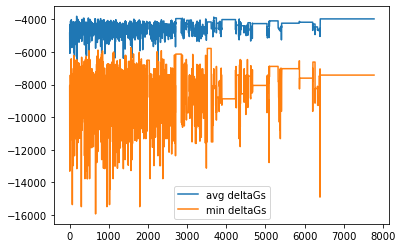

In [7]:
#Test settings for simulated annealing to get satisfactory settings before making a large parallel run to find the best primersets

#tune the T and length settings until you get satisfactory results
scores, pset, minhistory, avghistory, temp = sim_anneal(length = 0.2, T = 600, beta = 0.997)

#plot the performance of the primersets sampled over time
import matplotlib.pyplot as pyplot
%matplotlib inline
pyplot.plot(avghistory, label = "avg deltaGs")
pyplot.plot(minhistory, label = "min deltaGs")
pyplot.legend()


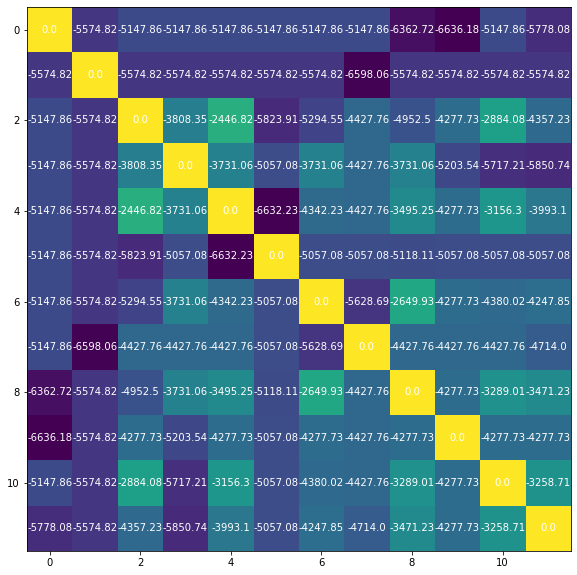

In [49]:
#plot the calculated pairwise deltaGs for all primers in this set
fig, ax = pyplot.subplots(figsize = (10,10))
ax.imshow(scores)
for i in range(len(scores)):
    for j in range(len(scores)):
        text = pyplot.text(j, i, scores[i, j],
                       ha="center", va="center", color="w")

In [9]:
#Run a parallelized version to get the best results
import multiprocessing
from joblib import Parallel, delayed

#number of instances to run to find the best one
num_iterations = 200
#number of cores to use
num_cores = 20

#do the parallelized runs
results = Parallel(n_jobs=num_cores)(delayed(sim_anneal)(length = 0.2, T = 600, beta = 0.997) for i in range(num_iterations)) 

In [10]:
#Summarize the results

#sort results by a mixture of min and avg deltaGs to find the best ones
results.sort(key = lambda x: (np.min(x[0]) + np.mean(x[0])), reverse = True) 

#take the top 10 and output as a csv file
with open("top10-sets.csv", "w") as outfile:
    for r in results[0:10]:
        print(f"Top 10 primersets {np.mean(r[0]), np.amin(r[0])}")
        for p in r[1]:
            outfile.write(f"{p.id}\t{p.fseq}\t{p.rseq}\t{p.ampliconlen}\t{np.mean(r[0])}\t{np.amin(r[0])}\n")



Top 10 primersets (-3729.4453999999996, -5574.82)
Top 10 primersets (-3747.1296, -5574.82)
Top 10 primersets (-3763.275, -5574.82)
Top 10 primersets (-3807.1708000000003, -5574.82)
Top 10 primersets (-3820.296800000001, -5574.82)
Top 10 primersets (-3829.6246, -5574.82)
Top 10 primersets (-3833.0665999999997, -5574.82)
Top 10 primersets (-3799.4390000000003, -5612.16)
Top 10 primersets (-3839.4842, -5574.82)
Top 10 primersets (-3839.5598000000005, -5574.82)


In [11]:
#save the whole results file just in case
with open("all-mplex-sets.pickle", "wb") as infile:
    pickle.dump(results, infile)
    